Saving data.csv to data (1).csv
Uploaded file: data (1).csv
Roll r=102303982, a_r=0.2, b_r=0.8999999999999999
Using NO2 column: no2
Valid sample size n = 419509

Estimated parameters:
mu      = 25.804091267939
sigma^2 = 342.610945104577
lambda  = 0.001459381281
c       = 0.021553085382


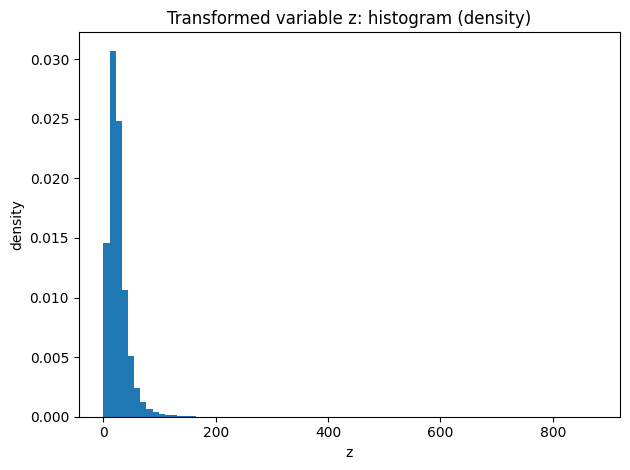

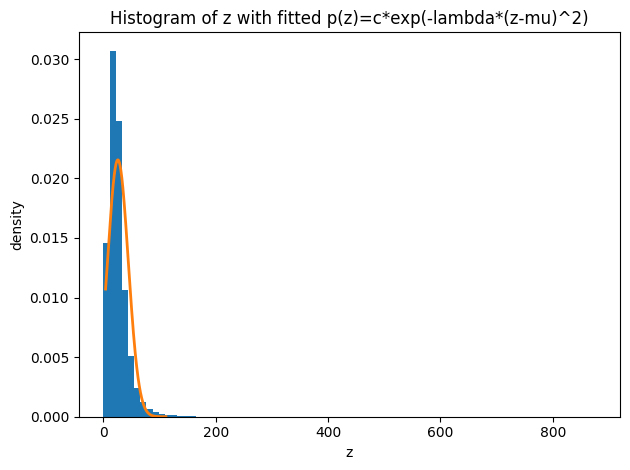


Saved outputs/estimated_parameters.csv and plots in outputs/


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files

uploaded = files.upload()

data = list(uploaded.keys())[0]
print("Uploaded file:", data)
NO2_COL_CANDIDATES = ["no2", "NO2", "No2", "no2(mg/m3)", "no2 (mg/m3)", "no2_µg/m3", "NO2 (µg/m3)"]

r = 102303982
a_r = 0.05 * (r % 7)
b_r = 0.3 * ((r % 5) + 1)

print(f"Roll r={r}, a_r={a_r}, b_r={b_r}")

df = pd.read_csv(data, encoding="cp1252", engine="python")

col_map = {c.lower().strip(): c for c in df.columns}
no2_col = None
for cand in NO2_COL_CANDIDATES:
    key = cand.lower().strip()
    if key in col_map:
        no2_col = col_map[key]
        break
if no2_col is None:
    for c in df.columns:
        if "no2" in c.lower():
            no2_col = c
            break

if no2_col is None:
    raise ValueError(f"Could not find NO2 column. Available columns: {list(df.columns)}")

print("Using NO2 column:", no2_col)

x = pd.to_numeric(df[no2_col], errors="coerce").dropna().astype(float).to_numpy()

x = x[x >= 0]

n = x.size
if n == 0:
    raise ValueError("No valid NO2 values found after cleaning.")

print("Valid sample size n =", n)

z = x + a_r * np.sin(b_r * x)

mu = float(np.mean(z))
sigma2_mle = float(np.mean((z - mu) ** 2))
lam = float(1.0 / (2.0 * sigma2_mle))
c = float(np.sqrt(lam / np.pi))

print("\nEstimated parameters:")
print(f"mu      = {mu:.12f}")
print(f"sigma^2 = {sigma2_mle:.12f}")
print(f"lambda  = {lam:.12f}")
print(f"c       = {c:.12f}")

os.makedirs("outputs", exist_ok=True)

plt.figure()
plt.hist(z, bins=80, density=True)
plt.title("Transformed variable z: histogram (density)")
plt.xlabel("z")
plt.ylabel("density")
plt.tight_layout()
plt.savefig("outputs/histogram.png", dpi=200)
plt.show()

z_min, z_max = np.percentile(z, [0.5, 99.5])
grid = np.linspace(z_min, z_max, 800)
pz = c * np.exp(-lam * (grid - mu) ** 2)

plt.figure()
plt.hist(z, bins=80, density=True)
plt.plot(grid, pz, linewidth=2)
plt.title("Histogram of z with fitted p(z)=c*exp(-lambda*(z-mu)^2)")
plt.xlabel("z")
plt.ylabel("density")
plt.tight_layout()
plt.savefig("outputs/fitted_curve.png", dpi=200)
plt.show()

out = pd.DataFrame(
    {
        "roll": [r],
        "a_r": [a_r],
        "b_r": [b_r],
        "n": [n],
        "mu": [mu],
        "sigma2_mle": [sigma2_mle],
        "lambda": [lam],
        "c": [c],
        "no2_column_used": [no2_col],
    }
)
out.to_csv("outputs/estimated_parameters.csv", index=False)
print("\nSaved outputs/estimated_parameters.csv and plots in outputs/")
